This notebook uses torch to train an LSTM to swingup, the advantage of using torch over keras is that we can more easily modify the implementation

In [1]:
import numpy as np
import pandas as pd

from numpy import cos, sin, pi
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline
import matplotlib.animation as animation

from IPython.display import HTML


import torch
import torch.nn as nn

# these are our own packages
from cartpole_class import Cartpole 
from torch_lstm_mod.lstm import LSTM

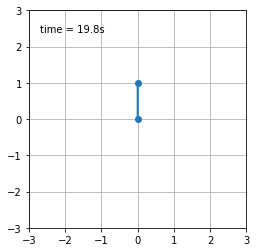

In [2]:
# time step
bot = Cartpole()

dt = 0.1
time = np.arange(0.0, 20, dt)

rad = np.pi / 180


num_trials = 1
num_states = 4
num_t = len(time)
y = np.zeros((num_t, num_states, num_trials))


for i in range(num_trials):
    # initial conditions
    theta = 0
    x = 0.0
    th_dot = 2*(i/num_trials) - 1  # an initial velocity, triggers the swing up control
    xdot = 0.0

    # initial state
    state = np.array([theta, x, th_dot, xdot])

    # integrate the ODE using scipy.integrate.
    u_hist = []
    y[:, :, i] = integrate.odeint(bot.derivs, state, time)



# clunky, but we get u after the fact
u = np.zeros((num_t, num_trials))
for i in range(num_trials):
    for t in range(num_t):
        u[t,i] = bot.control(y[t,:,i]) 

        
ani = bot.animate_cart(time, y[:,:,0])
HTML(ani.to_jshtml())



In [51]:
model = nn.LSTM(input_size = 4, hidden_size = 12, bias=True)

In [54]:
out, hidden = model(torch.FloatTensor(y[:,:,0]).view(200,1,4),(torch.randn(1,1,12), torch.randn(1,1,12)))
#out = model(ytr)

print(out.shape)
#print(hidden[0].shape)

torch.Size([200, 1, 12])


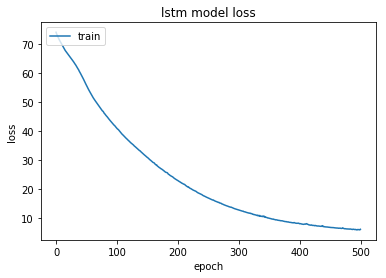

In [11]:
# Train LSTM

lstm_history = lstm_model.fit(y, u, epochs=500, verbose=0)
plt.plot(simple_history.history['loss'])
plt.title('lstm model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [14]:
# This is a closure that returns our NN controller
def make_controller(model):
    def nn_controller(q):
        if (q[0] < 140 * rad) or (q[0] > 220 * rad):
            return model.predict(q.reshape((1,4,1)))
        else:
            # balancing
            # LQR: K values from MATLAB
            k1 = 140.560
            k2 = -3.162
            k3 = 41.772
            k4 = -8.314
            u = -(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
            return u
        
    return nn_controller

simple_control = make_controller(simple_model)
lstm_control = make_controller(lstm_model)

In [28]:
simple_bot = Cartpole()
lstm_bot = Cartpole()

simple_bot.control = simple_control
lstm_bot.control = lstm_control

# initial conditions
theta = 0
x = 5
th_dot = .01 # an initial velocity, triggers the swing up control
xdot = 0.0
time = np.arange(0.0, 20, dt)

# initial state
state = np.array([theta, x, th_dot, xdot])

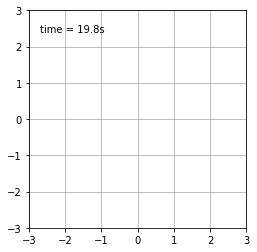

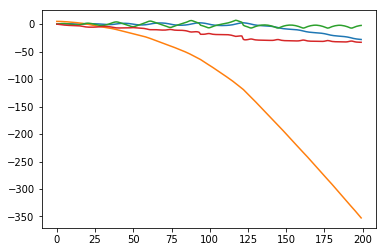

In [31]:
# integrate the ODE using scipy.integrate.
# Fill in our u after the fact..
y_simple = integrate.odeint(simple_bot.derivs, state, time)
u_simple = np.zeros((y.shape[0],1))
for t in range(num_t):
        u_simple[t] = simple_bot.control(y[t]) 

        
data = np.concatenate((y_simple, u_simple),axis=1)
names = ['theta','x','thetadot','xdot','u']
yf = pd.DataFrame(data = data, index = t_index, columns = names)


ani = simple_bot.animate_cart(time, y_simple)
HTML(ani.to_jshtml())

plt.figure()
plt.plot(y_simple[:,2])

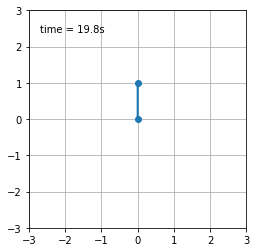

In [27]:
# integrate the ODE using scipy.integrate.
# Fill in our u after the fact..
y_lstm = integrate.odeint(lstm_bot.derivs, state, time)
u_lstm = np.zeros((y.shape[0],1))
for t in range(num_t):
        u_lstm[t] = lstm_bot.control(y[t]) 

        
data = np.concatenate((y_lstm, u_lstm),axis=1)
names = ['theta','x','thetadot','xdot','u']
yf = pd.DataFrame(data = data, index = t_index, columns = names)


ani = lstm_bot.animate_cart(time, y_lstm)
HTML(ani.to_jshtml())